這裡個概念是要先區分出該區域的不同情況

- 非尖峰→尖峰：非熱點→熱點
- 尖峰→非尖峰：非熱點→熱點
- 非尖峰→尖峰：熱點→非熱點
- 尖峰→非尖峰：熱點→非熱點

接著以這個情況建立四種label來帶入模型

In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from utils import get_grid, read_data, read_taiwan_specific

combined_data = read_data()
taiwan, grid_filter = read_taiwan_specific()

In [ ]:
peak = pd.read_csv("../ComputedDataV7/ForModel/final_data_peak.csv")
offpeak = pd.read_csv("../ComputedDataV7/ForModel/final_data_offpeak.csv")
final_full = pd.read_csv("../ComputedDataV7/ForModel/final_data_full.csv")

In [ ]:
# for col in select_group:
#     top_share = combined_data[col].value_counts(normalize=True).iloc[0]
#     if top_share > 0.95:
#         print(f"建議移除 {col}，其最大類別佔比達 {top_share:.2%}")

In [ ]:
def is_hot(val):
    if pd.isna(val) or val == 'Not Significant' or 'Coldspot' in str(val):
        return 0
    return 1

peak_state = peak['hotspot'].apply(is_hot)
off_state = offpeak['hotspot'].apply(is_hot)

conditions = [
    (off_state == 0) & (peak_state == 0),
    (off_state == 0) & (peak_state == 1),
    (off_state == 1) & (peak_state == 0),
    (off_state == 1) & (peak_state == 1)
]
choices = ['Stable_Safe', 'Emergent', 'Dissipated', 'Persistent']

final_full['transition_label'] = np.select(conditions, choices, default='Unknown')

print(final_full['transition_label'].value_counts())

final_full.drop(columns=['hotspot'], inplace=True)
final_full['速限-第1當事者_mean'] = (final_full['速限-第1當事者_mean'] - final_full['速限-第1當事者_mean'].min()) / (final_full['速限-第1當事者_mean'].max() - final_full['速限-第1當事者_mean'].min())

In [ ]:
from config import col_translation
final_full.rename(columns=col_translation, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

rescale_cols = [
    'num_mrt', 'lag_num_mrt', 'num_parking', 'lag_num_parking',
    'num_youbike', 'lag_num_youbike', 'num_speed_diff', 'lag_num_speed_diff',
    'num_bus_stop', 'lag_num_bus_stop'
]

scaler = MinMaxScaler()
final_full[rescale_cols] = scaler.fit_transform(final_full[rescale_cols])

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from collections import Counter

X = final_full.drop(columns=['transition_label', 'hotspot', 'accident_indices', 'geometry'], errors='ignore')
X.drop(columns=['車道劃分設施-分道設施-路面邊線名稱_無'], inplace=True, errors='ignore')
y = final_full['transition_label']

remove_lst = [
    '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱']

cols_to_drop = [c for c in X.columns if c.startswith(tuple(remove_lst))]
X = X.drop(columns=cols_to_drop)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## LR

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg'], 
    'max_iter': [1000, 1500, 2000]
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial'), 
    param_grid, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"原始訓練集分佈: {Counter(y_train)}")

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f"SMOTE+ENN 採樣後訓練集分佈: {Counter(y_train_resampled)}")
print(f"測試集分佈: {Counter(y_test)}")

grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best params: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
plt.figure(figsize=(10, 8))
plt.rcParams['font.sans-serif'] = ['PingFang TC']

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=best_model.classes_,
    cmap='Greens',
    normalize='true'
)

plt.xticks(rotation=45)
plt.show()

## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Stable_Safe vs Emergent & Persistent vs Dissipated
A = ['Persistent', 'Dissipated']
B = ['Stable_Safe', 'Emergent']

def train_model(X, y, type):
    mask = y.isin(type)
    X_type = X[mask]
    y_type = y[mask]

    X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type, test_size=0.2, random_state=42, stratify=y_type)

    # 對模型 A 的訓練集進行 SMOTEENN 處理
    smote_enn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_type, y_train_type)

    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42), # 已移除 class_weight='balanced'
        param_grid,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    # 訓練時使用 resampled 的資料
    rf_grid.fit(X_train_resampled, y_train_resampled)

    print(f"模型 A: {rf_grid.best_params_}")
    best_rf = rf_grid.best_estimator_
    y_pred = best_rf.predict(X_test_type)

    print(classification_report(y_test_type, y_pred))

    plt.figure(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test_type, y_pred,
        display_labels=best_rf.classes_,
        cmap='Blues',
        normalize='true'
    )
    plt.title("Model A: Stable_Safe vs Emergent")
    plt.show()

    return best_rf, X_test_type, y_test_type

In [ ]:
best_rf_A, X_test_A, y_test_A = train_model(X, y, A)
best_rf_B, X_test_B, y_test_B = train_model(X, y, B)

              precision    recall  f1-score   support

  Dissipated       0.19      0.77      0.30       754
  Persistent       0.94      0.54      0.69      5501

    accuracy                           0.57      6255
   macro avg       0.57      0.65      0.49      6255
weighted avg       0.85      0.57      0.64      6255



<Figure size 600x500 with 0 Axes>

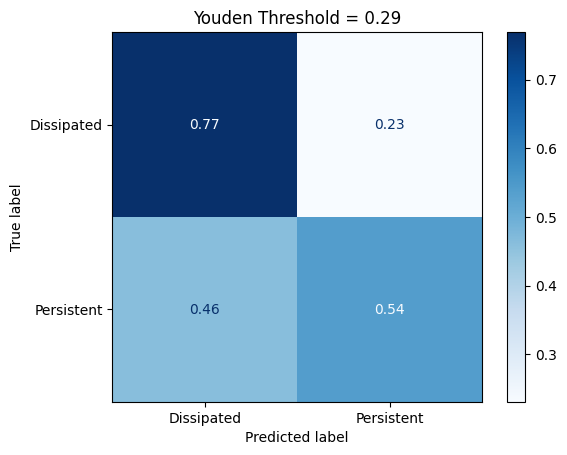

              precision    recall  f1-score   support

    Emergent       0.19      0.71      0.30       726
 Stable_Safe       0.96      0.69      0.80      6995

    accuracy                           0.69      7721
   macro avg       0.57      0.70      0.55      7721
weighted avg       0.89      0.69      0.76      7721



<Figure size 600x500 with 0 Axes>

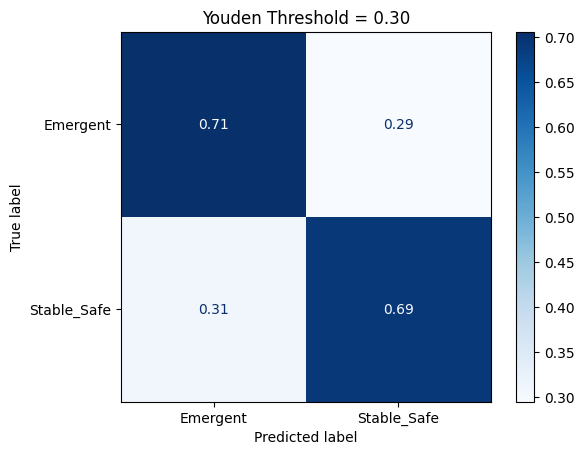

In [19]:
def roc_youden(best_rf, X_test, y_test, select_type= 'Emergent'):
    pos_idx = np.where(best_rf.classes_ == select_type)[0][0]
    y_prob = best_rf.predict_proba(X_test)[:, pos_idx]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=select_type)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]

    neg_class = [c for c in best_rf.classes_ if c != select_type][0]
    y_pred_optimal = np.where(y_prob >= optimal_threshold, select_type, neg_class)

    print(classification_report(y_test, y_pred_optimal))

    plt.figure(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_optimal,
        display_labels=best_rf.classes_,
        cmap='Blues',
        normalize='true'
    )
    plt.title(f"Youden Threshold = {optimal_threshold:.2f}")
    plt.show()

roc_youden(best_rf_A, X_test_A, y_test_A, select_type='Dissipated')
roc_youden(best_rf_B, X_test_B, y_test_B, select_type='Emergent')

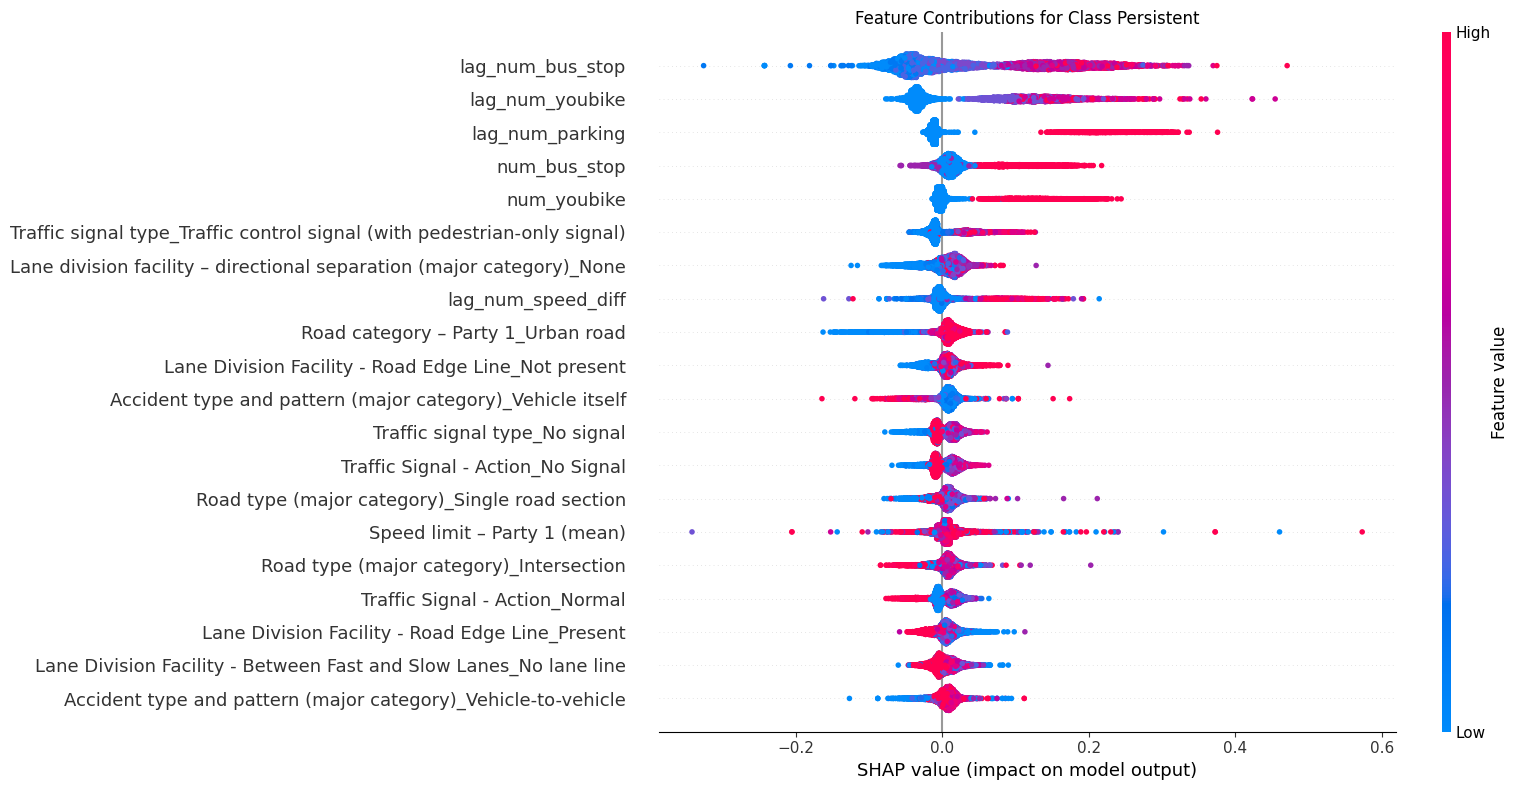

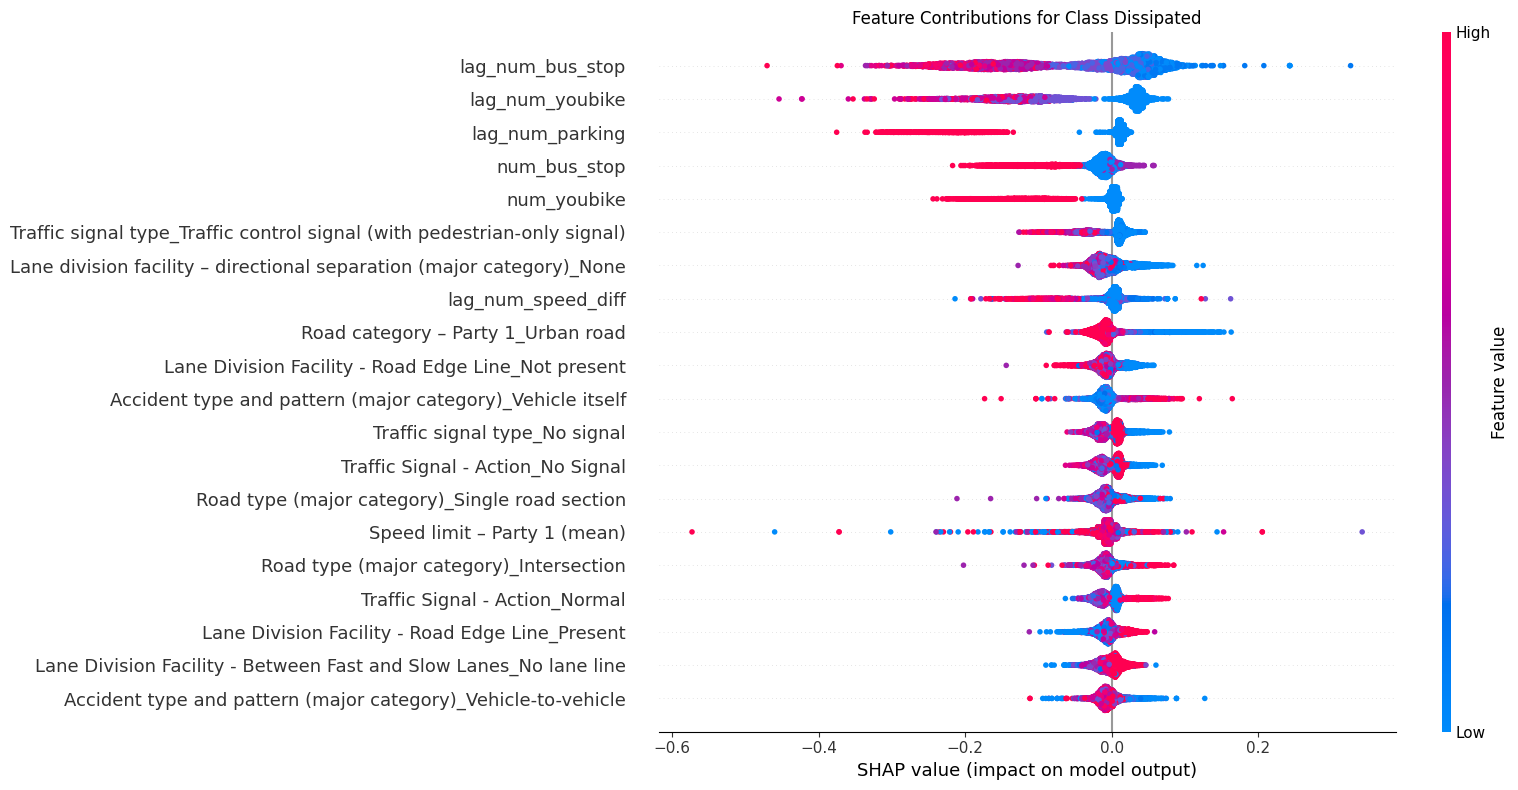

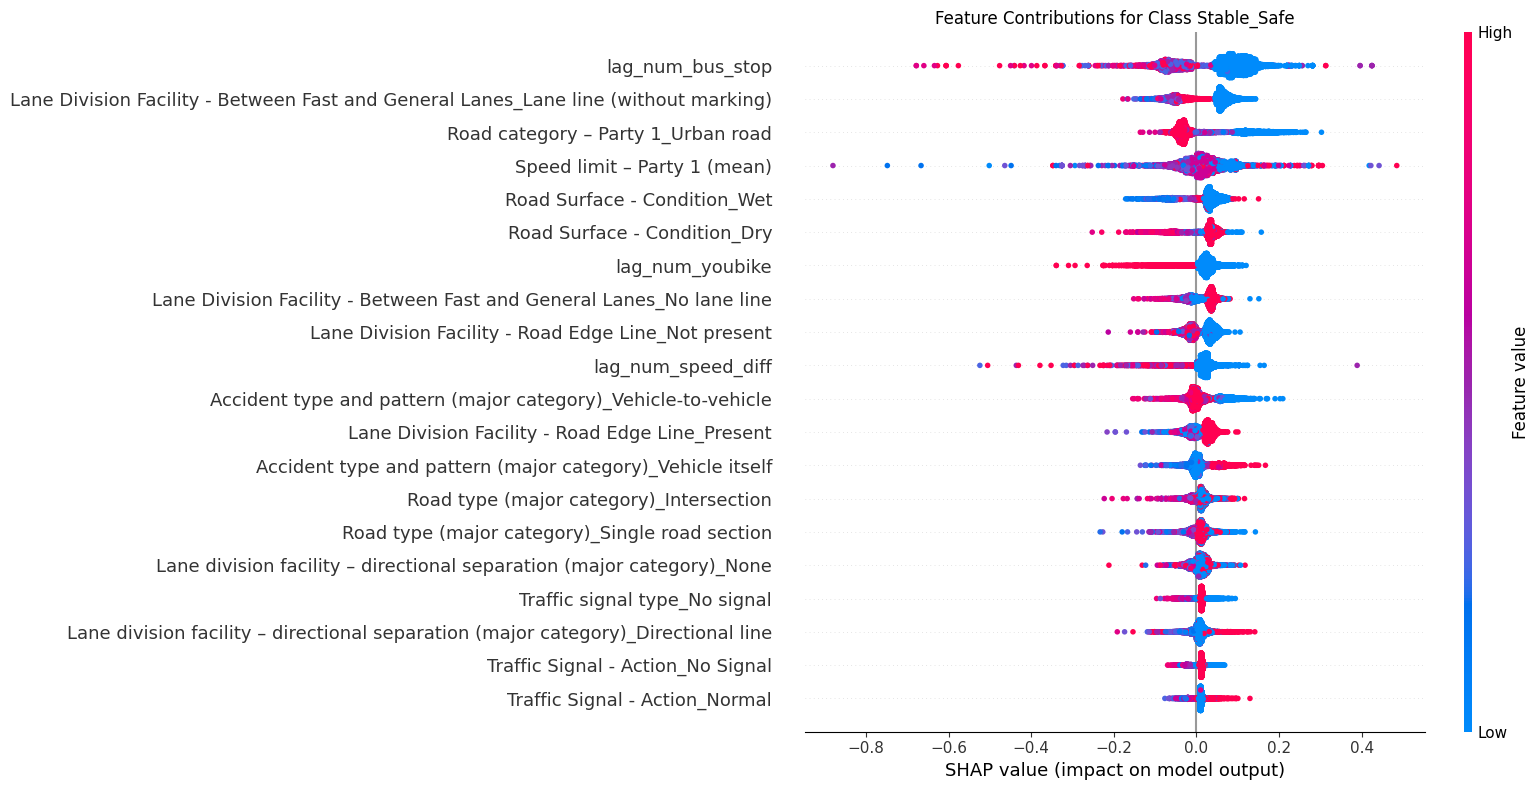

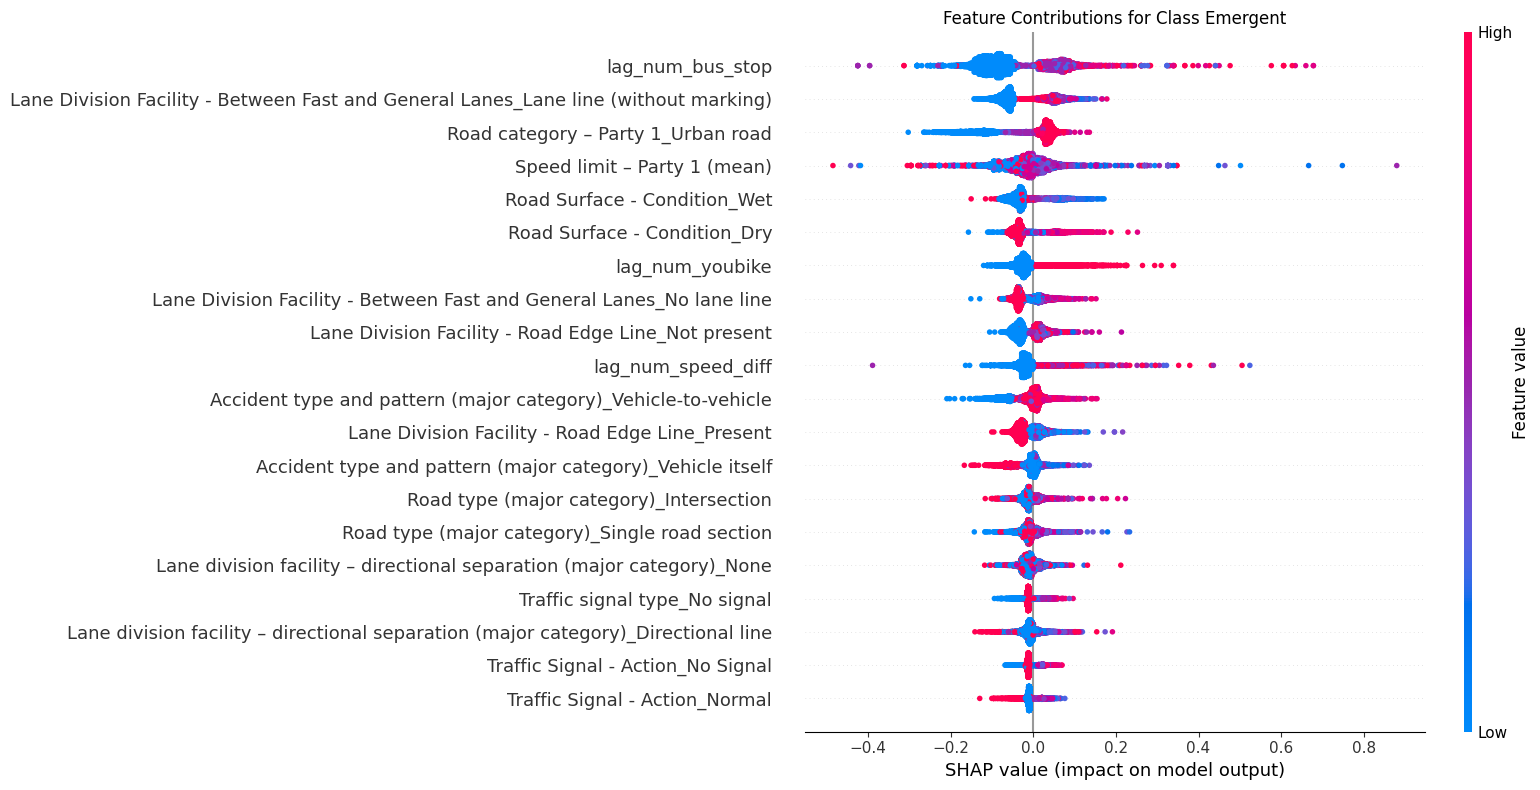

In [29]:
import shap

def shap_plot(best_model, test_x, test_y):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(test_x, approximate=True)

    for target_label in test_y.unique():
        class_idx = list(best_model.classes_).index(target_label)

        plt.figure(figsize=(16, 8))
        plt.title(f"Feature Contributions for Class {target_label}")

        if isinstance(shap_values, list):
            target_shap_values = shap_values[class_idx]
        else:
            target_shap_values = shap_values[:, :, class_idx]

        shap.summary_plot(target_shap_values, test_x, plot_size=(16, 8))

    return shap_values

shap_values_A = shap_plot(best_rf_A, X_test_A, y_test_A)
shap_values_B = shap_plot(best_rf_B, X_test_B, y_test_B)

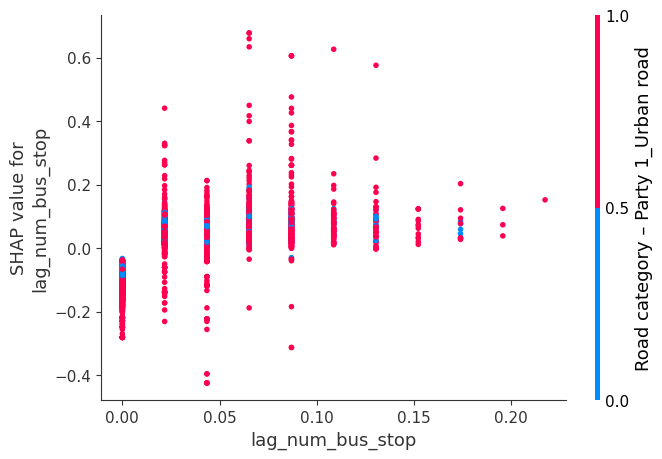

In [77]:
# best_rf_B.classes_
# target_label = 'Emergent'
target_label = 'Emergent'
best_rf = best_rf_B
shap_value = shap_values_B
X_test = X_test_B

class_idx = list(best_rf.classes_).index(target_label)

if isinstance(shap_value, list):
    target_shap = shap_value[class_idx]
else:
    target_shap = shap_value[:, :, class_idx]

# shap.dependence_plot(
#     "num_youbike", 
#     target_shap,
#     X_test,
#     interaction_index="Road type (major category)_Single road section"
# )
shap.dependence_plot(
    "lag_num_bus_stop", 
    target_shap,
    X_test,
    # interaction_index="Road type (major category)_Intersection"
)

## MLP

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(final_full['transition_label'])

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y_encoded)

In [ ]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [2000]
}
mlp_grid = GridSearchCV(
    MLPClassifier(random_state=42, early_stopping=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

mlp_grid.fit(X_resampled, y_resampled)

print(f"Best params: {mlp_grid.best_params_}")
best_mlp = mlp_grid.best_estimator_

In [ ]:
y_test_le = le.transform(y_test)
y_pred = best_mlp.predict(X_test)

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test_le, y_pred,
    display_labels=le.classes_,
    cmap='RdPu',
    normalize='true'
)
plt.show()